# Binary Classification Prediction Visualization

In [90]:
!pwd
# %cd ..

/export/share/krausef99dm/master-thesis/src


In [92]:
import os
import pickle
import torch
import pandas as pd
from itertools import compress

from utils.knowledge_db import TOKENS, CODON_MAP_DNA, TISSUES
INV_CODON_MAP_DNA = {v: k for k, v in CODON_MAP_DNA.items()}
TISSUES_DICT = {k: v for k, v in enumerate(TISSUES)}

# TODO print tissue name and if tissue is already identified as GC or AT favouring based on Hernandez-Alias et al
tissue_numbers = {
    "GC": [11, 19, 10, 15],  # Kidney, Rectum, Heart, Ovary
    "AT": [13, 2, 25, 4]     # Lung, Brain, Testis, Duodenum
}

## CLASSIFICATION

In [93]:
# best model (pretrained PTRnet)
predictions_path = "/export/share/krausef99dm/runs/binary/ptrnet/31_ptrnet_freq/predictions"

path_seq_val = "/export/share/krausef99dm/data/data_test/test_9.0k_data.pkl"

In [94]:
df_val = pd.read_csv(os.path.join(predictions_path, "predictions_val_fold-0.csv"), index_col=0)

In [95]:
df_val

,tissue_ids,target,prediction
0,6,1,0.340291
1,16,0,0.534514
2,1,1,0.310510
3,8,0,0.282197
4,3,1,0.300825
...,...,...,...
2768,24,0,0.642258
2769,21,0,0.781745
2770,23,1,0.582704
2771,8,1,0.273913


In [97]:
# load val data
with open(path_seq_val, 'rb') as f:
    rna_data, tissue_ids, targets, targets_bin =  pickle.load(f)

In [99]:
# filter data
mask = torch.ones((len(rna_data)), dtype=torch.bool)
mask_bin = targets_bin > 0  # only keep low-/high-PTR samples
mask = mask_bin & mask
#targets_bin -= 1  # make binary class 0/1 encoded

mask_len = torch.tensor([len(d) <= 9000 for d in rna_data])
mask = mask_len & mask

rna_data_masked = list(compress(rna_data, mask))
tissue_ids_masked = list(compress(tissue_ids.tolist(), mask))

In [100]:
len(rna_data_masked)

2773

In [101]:
df_val

,tissue_ids,target,prediction
0,6,1,0.340291
1,16,0,0.534514
2,1,1,0.310510
3,8,0,0.282197
4,3,1,0.300825
...,...,...,...
2768,24,0,0.642258
2769,21,0,0.781745
2770,23,1,0.582704
2771,8,1,0.273913


In [102]:
#df_val["rna_data"] = rna_data_masked
df_val["prediction_bin"] = [1 if i > 0.5 else 0 for i in df_val.prediction]
df_val["correct_pred"] = df_val.target == df_val.prediction_bin

df_val["tissue_id"] = tissue_ids_masked

rna_numeric = ["".join(list(map(str, rna_data[i][:, 0].tolist()))) for i in range(len(rna_data_masked))]
df_val["rna"] = ["".join([TOKENS[int(i) - 1] for i in rna]) for rna in rna_numeric]
df_val["coding_area"] = ["".join(list(map(str, rna_data[i][:, 1].tolist()))) for i in range(len(rna_data_masked))]
df_val["seq_len"] = [len(rna) for rna in rna_data_masked]

## Checkpoint

In [104]:
# store df_val
df_val.to_csv("../experiments/visualisation/data/ptrnet_31_preds_extended.csv")

In [ ]:
# load df_val
df_val = pd.read_csv("data/ptrnet_31_preds_extended.csv")

## Feature engineering

In [45]:
# legacy
def compute_gc_content(encoded_str: str) -> float:
    """
    Compute GC content from a string of token indices (as characters).
    """
    decoded = [TOKENS[int(ch)-1] for ch in encoded_str if ch.isdigit()]
    gc_count = sum(1 for base in decoded if base in ['G', 'C'])
    valid_bases = sum(1 for base in decoded if base in ['A', 'C', 'G', 'T'])
    return gc_count / valid_bases if valid_bases > 0 else 0.0

In [86]:
# new
def gc_ending_codon_fraction(seq):
    codons = [seq[i:i+3] for i in range(0, len(seq) - len(seq) % 3, 3)]
    gc_ending = [c for c in codons if c[-1] in {'G', 'C'}]
    return len(gc_ending) / len(codons) if codons else 0

In [87]:
df_val["gc_content"] = df_val["rna"].apply(gc_ending_codon_fraction)

In [88]:
# in depth analysis only possible for val data, as train data is shuffled which prevents joininig dfs
df = df_val

In [89]:
df

,tissue_ids,target,prediction,prediction_bin,correct_pred,tissue_id,rna,coding_area,seq_len,gc_content
0,6,1,0.340291,0,False,6,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,0.461012
1,16,0,0.534514,1,False,16,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,0.461012
2,1,1,0.310510,0,False,1,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,1761,0.461012
3,8,0,0.282197,0,True,8,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,1761,0.461012
4,3,1,0.300825,0,False,3,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2767,0.461012
...,...,...,...,...,...,...,...,...,...,...
2768,24,0,0.642258,1,False,24,CTGGTTCAGGGGCTAGAAAAGAGCGTCGATGCCGGCGGCAGTGATG...,5555555555555555555555555555555555555555555555...,1998,0.386838
2769,21,0,0.781745,1,False,21,CTGGTTCAGGGGCTAGAAAAGAGCGTCGATGCCGGCGGCAGTGATG...,5555555555555555555555555555555555555555555555...,3595,0.386838
2770,23,1,0.582704,1,True,23,CTGGTTCAGGGGCTAGAAAAGAGCGTCGATGCCGGCGGCAGTGATG...,5555555555555555555555555555555555555555555555...,3595,0.386838
2771,8,1,0.273913,0,False,8,CTGGTTCAGGGGCTAGAAAAGAGCGTCGATGCCGGCGGCAGTGATG...,5555555555555555555555555555555555555555555555...,8143,0.386838


## Analysis

<Axes: >

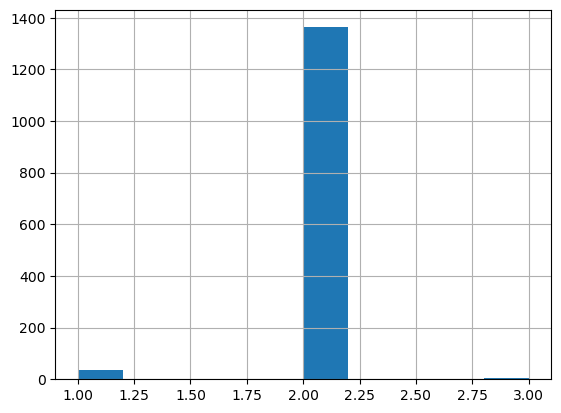

In [50]:
# almost all sequences appear twice (in val set)
df.groupby("rna").correct_pred.count().hist()

<Axes: >

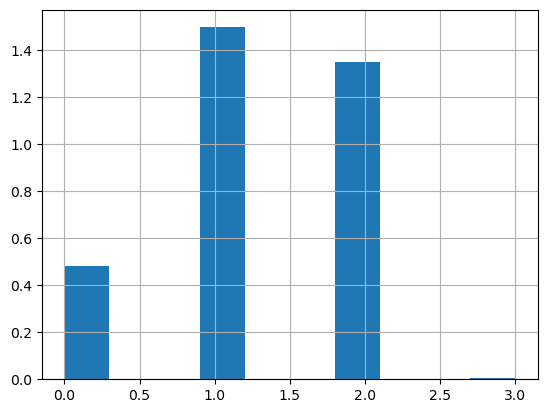

In [51]:
df.groupby("rna").correct_pred.sum().hist(density=True)
# 0: low- and high PTR sample of mRNA classified wrong: around 17%
# 1: only one of both is classified correctly: around 43%
# 2: both are correctly predicted: 39%

### Descriptive analysis

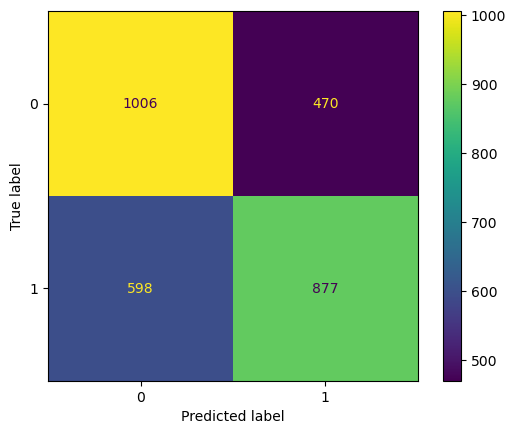

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df.target, df.prediction_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [36]:
df.groupby("correct_pred").seq_len.mean()

correct_pred
False    1851.196629
True     1760.064790
Name: seq_len, dtype: float64

In [13]:
# MAMBA + PRETRAIN
df.groupby("correct_pred").seq_len.describe()

,count,mean,std,min,25%,50%,75%,max
correct_pred,,,,,,,,
False,896.0,2827.486607,1618.124417,421.0,1649.5,2477.0,3698.0,8974.0
True,1456.0,2830.230082,1661.478273,443.0,1649.5,2456.5,3656.0,8974.0


In [80]:
# FREQ
df.groupby("correct_pred").seq_len.describe()

,count,mean,std,min,25%,50%,75%,max
correct_pred,,,,,,,,
False,889.0,2859.039370,1643.291594,421.0,1682.0,2484.0,3699.0,8974.0
True,1463.0,2811.043746,1645.936245,443.0,1613.0,2448.0,3636.0,8974.0


In [34]:
# Analysis of very confident mistakes
tau = 0.3

confident_mistakes = df[(~df.correct_pred) & 
   ( ((df.target == 1) & (df.prediction < tau )) | 
     ((df.target == 0) & (df.prediction > 1 - tau)) 
   )
]

In [41]:
confident_mistakes.groupby("all_wrong").describe()

target                                              prediction  \
           count      mean       std  min  25%  50%  75%  max      count   
all_wrong                                                                  
False      112.0  0.696429  0.461866  0.0  0.0  1.0  1.0  1.0      112.0   
True        91.0  0.593407  0.493919  0.0  0.0  1.0  1.0  1.0       91.0   

                     ...  seq_len         prediction_bin                      \
               mean  ...      75%     max          count      mean       std   
all_wrong            ...                                                       
False      0.412465  ...  3698.75  7360.0          112.0  0.303571  0.461866   
True       0.472396  ...  3688.50  7321.0           91.0  0.406593  0.493919   

                                    
           min  25%  50%  75%  max  
all_wrong                           
False      0.0  0.0  0.0  1.0  1.0  
True       0.0  0.0  0.0  1.0  1.0  

[2 rows x 32 columns]

In [40]:
df[~df.index.isin(confident_mistakes.index)].groupby("all_wrong").seq_len.describe()

,count,mean,std,min,25%,50%,75%,max
all_wrong,,,,,,,,
False,1856.0,2856.537716,1668.928464,443.0,1668.0,2478.0,3721.25,8974.0
True,293.0,2714.122867,1503.504946,538.0,1638.0,2381.0,3366.00,8477.0


### Visual Analysis

#### Distribution of Predictions

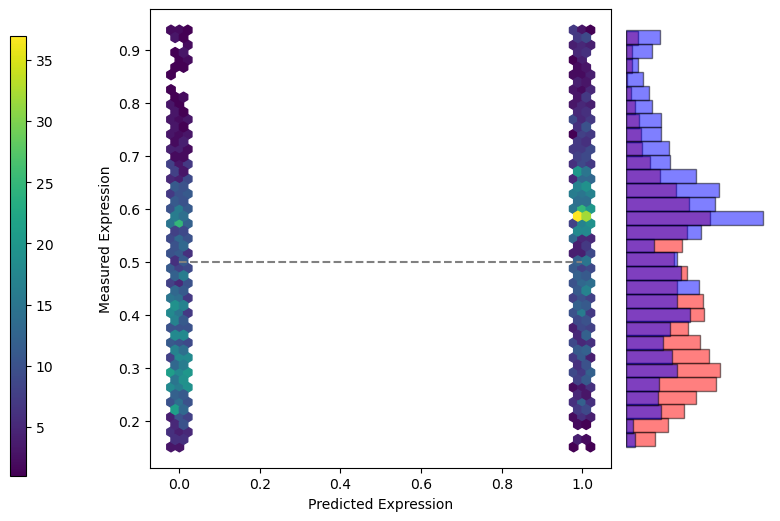

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

category_colors = {
    0: "red",
    1: "blue",
}

# Example data
np.random.seed(42)
x = df['target']
x_jitter = x + np.random.normal(0, 0.02, len(x))
x_jitter = np.clip(x_jitter, x - 0.02, x + 0.02)

y = df['prediction']

# Calculate correlations
pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)

# Create the figure
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4, hspace=0.1, wspace=0.1)

# Main plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
hb = ax_main.hexbin(x_jitter, y, gridsize=50, cmap='viridis', mincnt=1)
# ax_main.plot([x.min(), x.max()], [x.min(), x.max()], 'gray', linestyle='--')
ax_main.plot([x.min(), x.max()], [0.5, 0.5], 'gray', linestyle='--')
ax_main.set_xlabel('Predicted Expression')
ax_main.set_ylabel('Measured Expression')

# Add colorbar on the left
cax = fig.add_axes([-0.05, 0.1, 0.02, 0.55])  # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cax, orientation='vertical')
# cb.set_label('Density')

# Add correlation text
# n_samples = len(x)
# ax_main.text(0.05, 0.95, f"Pearson's r = {pearson_corr:.3f}\nSpearman's r = {spearman_corr:.2f}\nN = {n_samples}",
#              transform=ax_main.transAxes, verticalalignment='top', fontsize=12)

# Top histogram
# ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
# ax_top.hist(x, bins=30, color='gray', edgecolor='black', alpha=0.7)
# ax_top.axis('off')

# Right histogram (rotated)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
# ax_right.hist(y, bins=30, color='gray', edgecolor='black', alpha=0.7, orientation='horizontal')
for category in np.unique(x):
    group_y = y[x == category]
    ax_right.hist(group_y, bins=30, color=category_colors[category], edgecolor='black', alpha=0.5, orientation='horizontal', label=category)

ax_right.axis('off')

plt.show()


#### mRNA specific predictive power

In [33]:
# Compute a Series indicating if an mRNA is only wrongly classified (sum==0)
only_wrong = df.groupby("rna")["correct_pred"].sum() == 0

# Map the boolean result to a new column in the original df
df["all_wrong"] = df["rna"].map(only_wrong)

In [59]:
all_wrong_sample = df[df["all_wrong"]]
all_wrong_sample.describe()

,target,prediction,seq_len,prediction_bin
count,384.000000,384.000000,384.000000,384.000000
mean,0.500000,0.497300,2745.226562,0.500000
std,0.500652,0.163080,1550.468658,0.500652
min,0.000000,0.155630,421.000000,0.000000
25%,0.000000,0.376328,1621.000000,0.000000
50%,0.500000,0.500016,2405.000000,0.500000
75%,1.000000,0.602139,3440.000000,1.000000
max,1.000000,0.932399,8477.000000,1.000000


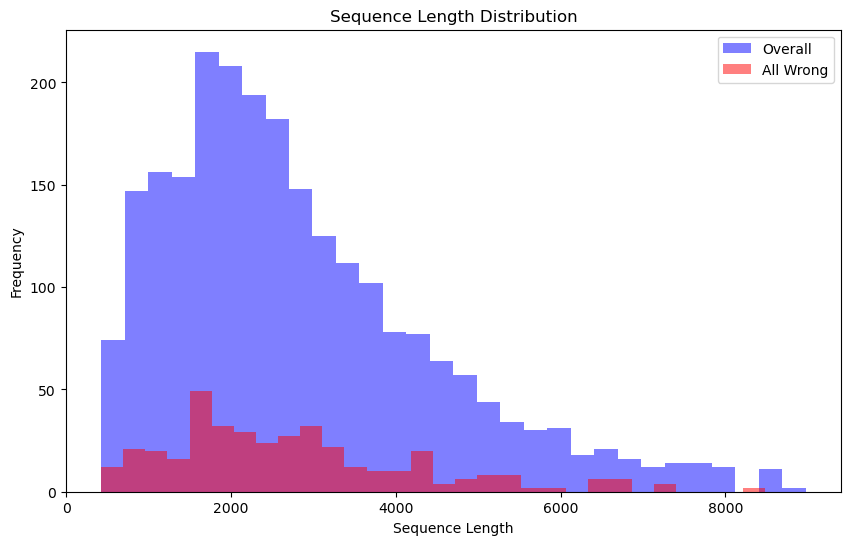

In [60]:
plt.figure(figsize=(10, 6))

# Histogram for all samples
plt.hist(df['seq_len'], bins=30, alpha=0.5, label='Overall', color='blue')

# Histogram for samples where 'all_wrong' is True
plt.hist(df.loc[df['all_wrong'], 'seq_len'], bins=30, alpha=0.5, label='All Wrong', color='red')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sequence Length Distribution')
plt.show()


## Show correlations

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

def plot_correlations(df, feature_name, tissue_id=None):
    df_subset = df
    if tissue_id is not None:
        df_subset = df[df.tissue_id.isin([tissue_id])].copy()

    y_true = df_subset.target
    y_pred = df_subset.prediction
    feature = df_subset[feature_name]

    print("Tissue displayed:", TISSUES_DICT[tissue_id], f"({tissue_id})")
    if tissue_id in tissue_numbers["GC"]:
        print("NOTE: Tissue GC boosted acc to Hernandez et al!")
    if tissue_id in tissue_numbers["AT"]:
        print("NOTE: Tissue AT boosted acc to Hernandez et al!")
    print("Counts per target:", df.groupby(["tissue_id", "target"]).prediction.count().loc[tissue_id])
    print("Correlation", np.corrcoef(feature, y_pred)[0])

    # Define colors for class 0 and 1
    color_map = {0: 'tab:blue', 1: 'tab:red'}
    colors = y_true.map(color_map)

    plt.figure(figsize=(8, 6))

    # Shaded regions
    #plt.axhspan(0.5, 1.0, color='red', alpha=0.05)
    #plt.axhspan(0.0, 0.5, color='blue', alpha=0.05)

    if max(y_pred) > 0.5:
        plt.axhspan(0.5, max(y_pred) * 1.1, color='red', alpha=0.05)
    if min(y_pred) < 0.5:
        plt.axhspan(min(y_pred) * 0.9, 0.5, color='blue', alpha=0.05)

    # Scatter plot
    plt.scatter(feature, y_pred, c=colors, alpha=0.8, linewidth=0.5)

    # Axis labels and threshold line
    plt.xlabel(feature_name)
    plt.ylabel("Predicted Score")
    plt.plot([min(feature)*0.9, max(feature)*1.1], [0.5, 0.5], color='grey', linestyle='--')
    plt.title(f"Predicted Score vs. {feature_name}")

    # Legend
    legend_elements = [
        mpatches.Patch(color='tab:red', label='High PTR (1)'),
        mpatches.Patch(color='tab:blue', label='Low PTR (0)')
    ]
    plt.legend(handles=legend_elements, title="True Class", loc="best")

    plt.tight_layout()
    plt.show()

In [127]:
nr_iter = iter(range(29))

Tissue displayed: Kidney (11)
NOTE: Tissue GC boosted acc to Hernandez et al!
Counts per target: target
0    71
1    61
Name: prediction, dtype: int64
Correlation [1.         0.86297879]


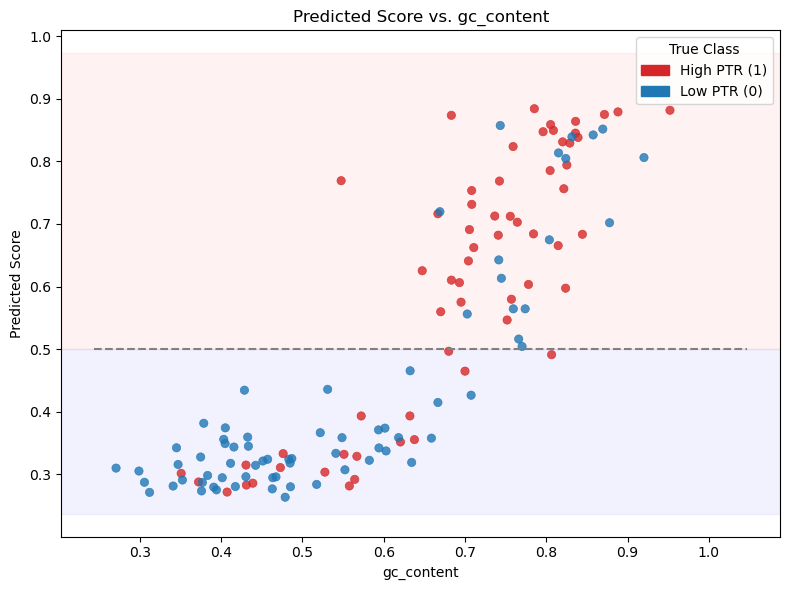

In [140]:
# blue should be below the line
plot_correlations(df, "gc_content", next(nr_iter))  # gc_content, seq_len

Tissue displayed: Kidney (11)
NOTE: Tissue GC boosted acc to Hernandez et al!
Counts per target: target
0    71
1    61
Name: prediction, dtype: int64
Correlation [1.         0.86297879]


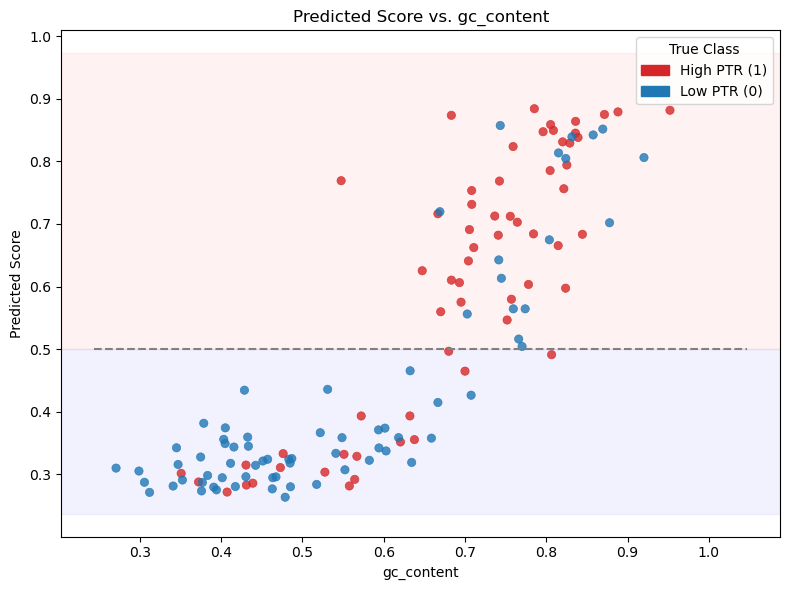

In [141]:
# blue should be below the line
plot_correlations(df, "gc_content", 11)  # gc_content, seq_len

#### Correlation with specific sequences

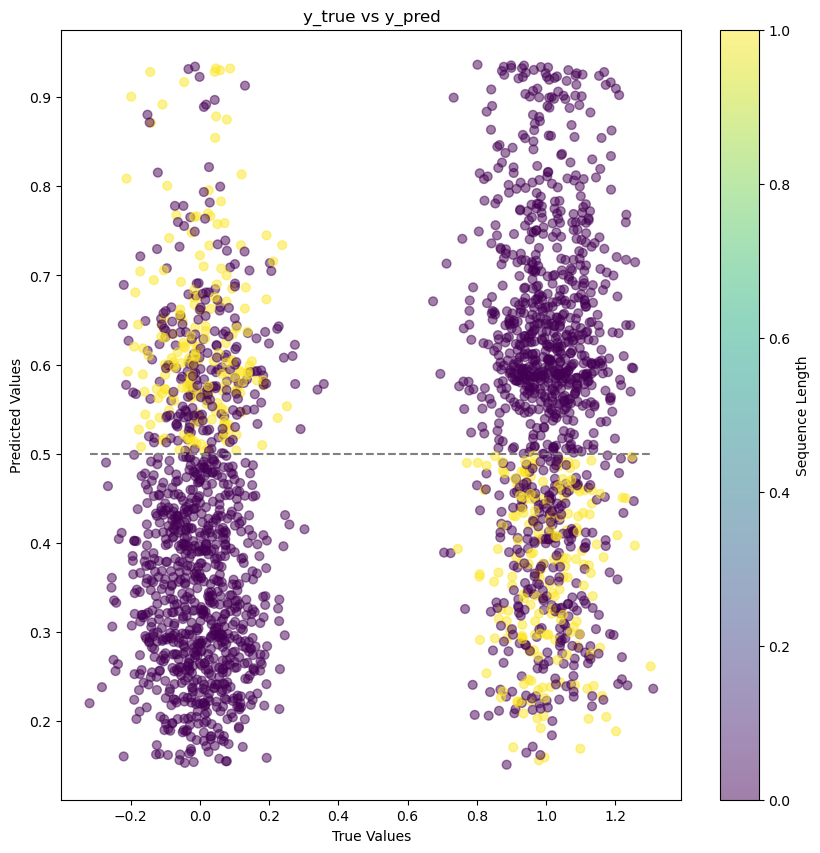

In [45]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))

y_true = df.target + np.random.normal(0, 0.1, len(df.target))
y_pred = df.prediction
seq_lengths = df.seq_len

cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)

# Scatter plot with colors
scatter = plt.scatter(y_true, y_pred, alpha=0.5, s=40, c=df.all_wrong, cmap=cmap)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('y_true vs y_pred')

# Add a colorbar associated with the scatter plot
cbar = plt.colorbar(scatter)
cbar.set_label('Sequence Length')

min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')

plt.show()

# Does the model mainly fail for specific sequences (yellow: prediction for both low and high ptr was wrong)

#### Correlations with sequence length

In [251]:
import matplotlib.pyplot as plt
import numpy as np

def plot_corr_with_seq_len(df, selected_tissues=[]):
    plt.figure(figsize=(10, 10))
    if selected_tissues:
        df = df[df.tissue_id.isin(selected_tissues)].copy()
    
    y_true = df.target + np.random.normal(0, 0.1, len(df.target))
    y_pred = df.prediction
    seq_lengths = df.seq_len
    
    # Normalize sequence lengths for coloring
    norm = plt.Normalize(min(seq_lengths), max(seq_lengths))
    cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)
    
    # Scatter plot with colors
    scatter = plt.scatter(y_true, y_pred, alpha=0.5, s=40, c=seq_lengths, cmap=cmap, norm=norm)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred')
    
    # Add a colorbar associated with the scatter plot
    cbar = plt.colorbar(scatter)
    cbar.set_label('Sequence Length')
    
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')
    
    plt.show()

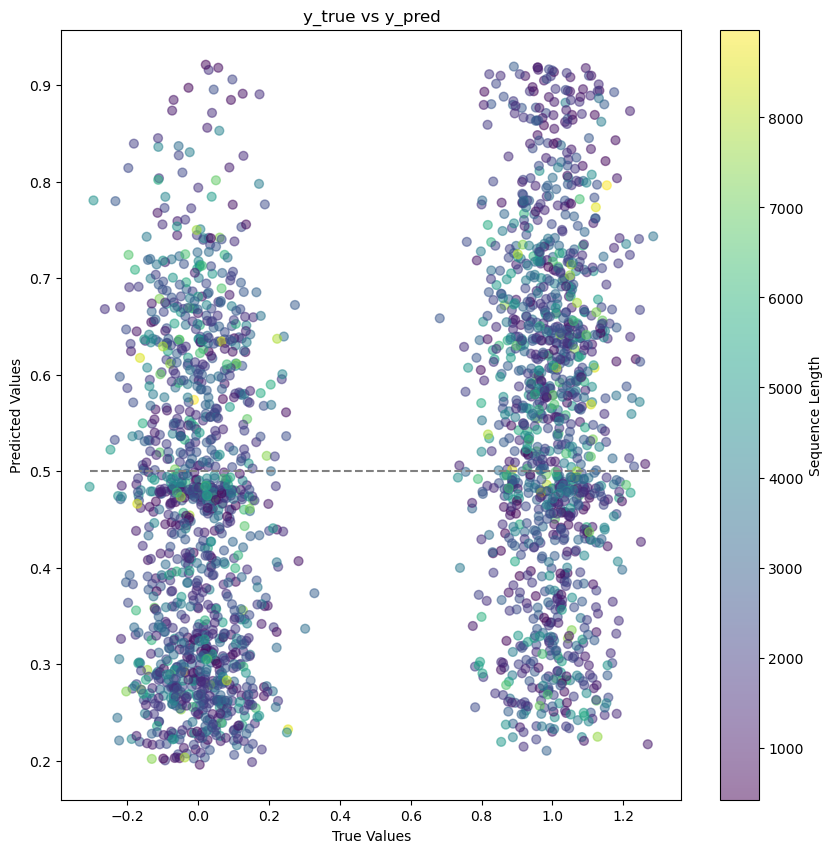

In [81]:
import matplotlib.pyplot as plt
import numpy as np

plot_corr_with_seq_len(df)
# FREQ

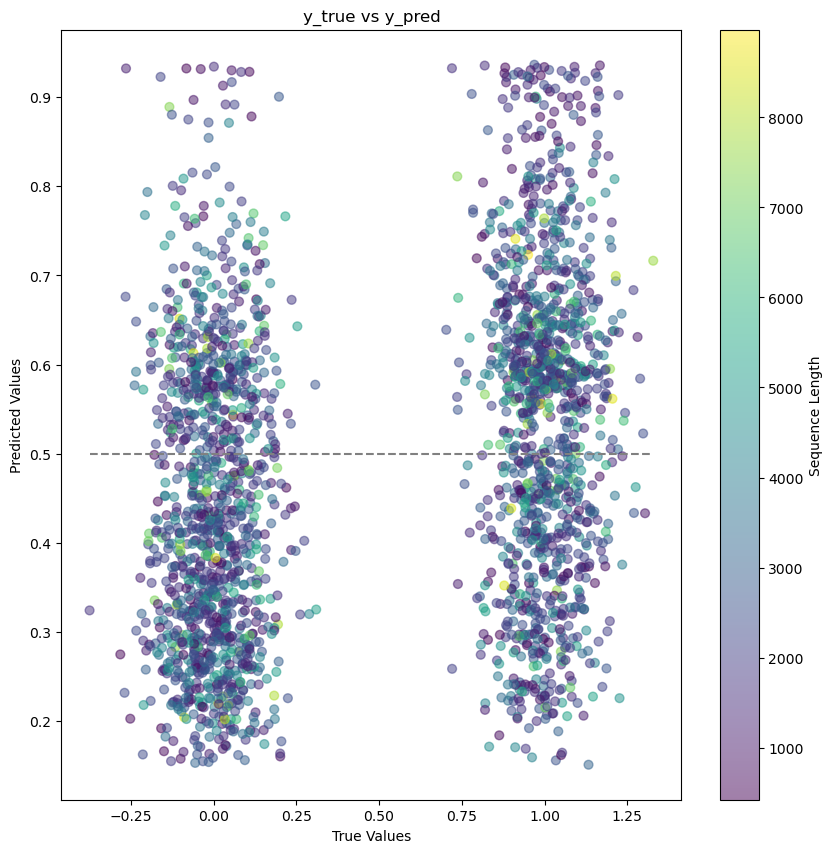

In [252]:
plot_corr_with_seq_len(df)

In [255]:
nr_iter = iter(range(28))

[4]
target
0    28
1    21
Name: prediction, dtype: int64


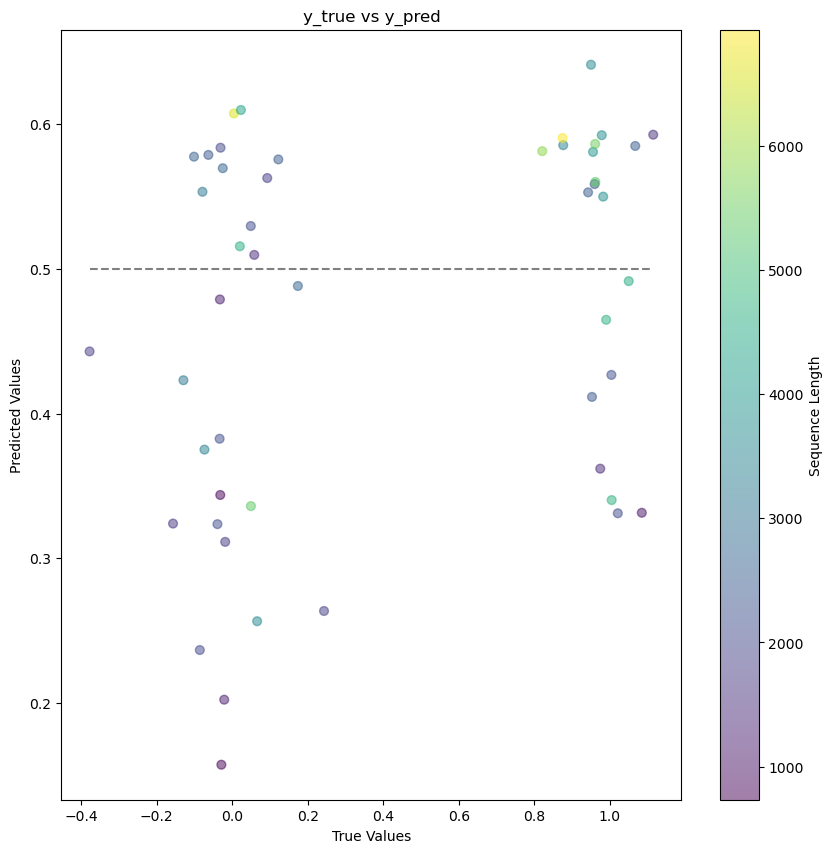

In [260]:
nr = next(nr_iter)
selected_tissues = [nr]
print(selected_tissues)
print(df.groupby(["tissue_id", "target"]).prediction.count().loc[nr])

plot_corr_with_seq_len(df, selected_tissues)

#### Correlation with GC content

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# Filter dataframe
def plot_corr_with_gc_content(df, selected_tissues):
    plt.figure(figsize=(10, 10))
    df = df[df.tissue_id.isin(selected_tissues)].copy()
    
    y_true = df.target + np.random.normal(0, 0.04, len(df.target))
    y_pred = df.prediction
    seq_lengths = df.gc_content
    
    # Normalize sequence lengths for coloring
    norm = plt.Normalize(min(seq_lengths), max(seq_lengths))
    cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)
    
    # Scatter plot with colors
    scatter = plt.scatter(y_true, y_pred, alpha=0.4, s=40, c=seq_lengths, cmap=cmap, norm=norm)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred')
    
    # Add a colorbar associated with the scatter plot
    cbar = plt.colorbar(scatter)
    cbar.set_label('GC Content')
    
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')
    
    plt.show()

In [215]:
nr_iter = iter(range(29))

[1, 2, 3, 4, 5]


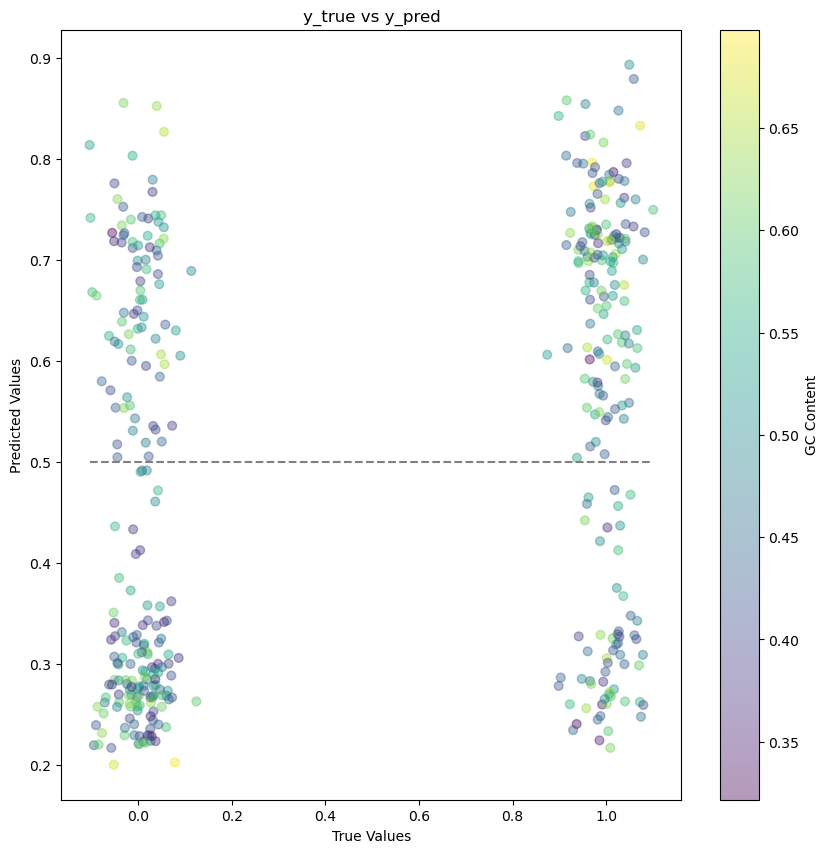

In [211]:
# Choose subset of tissue IDs to analyze

# nr = next(nr_iter)
selected_tissues = [1,2,3,4,5]
print(selected_tissues)
# print(df.groupby(["tissue_id", "target"]).prediction.count().loc[nr])

plot_corr_with_gc_content(df, selected_tissues)

#### Correlation among tissue ids

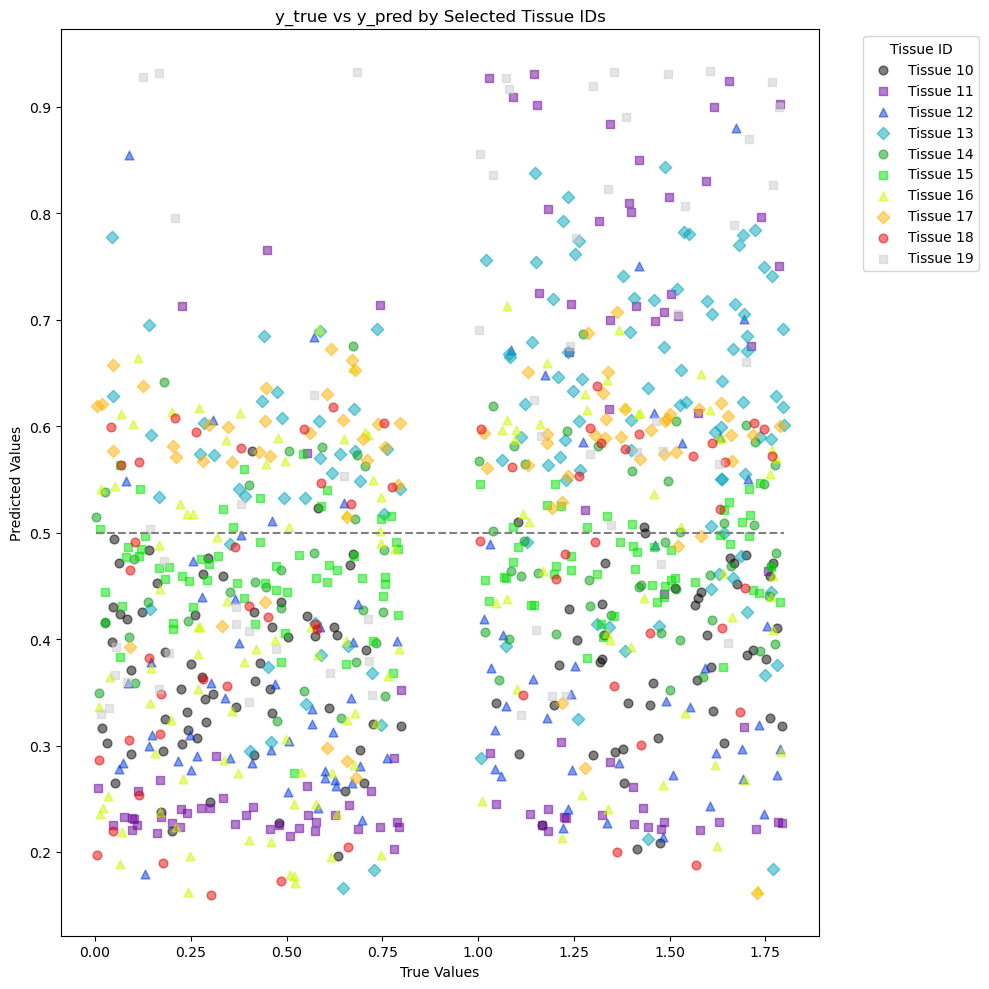

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Choose subset of tissue IDs to analyze
#selected_tissues = list(range(10))
selected_tissues = list(range(10,20))
#selected_tissues = list(range(20,29))

# Filter dataframe
subset_df = df[df.tissue_id.isin(selected_tissues)].copy()

# Check if the subset is non-empty
if subset_df.empty:
    raise ValueError("No data available for the selected tissue IDs.")

plt.figure(figsize=(10, 10))

# Generate y_true (adding a small uniform noise) and y_pred
y_true = subset_df.target + np.random.uniform(0, 0.8, len(subset_df))
y_pred = subset_df.prediction

# Fix the y-scale to [0, 1]
#plt.ylim(0, 1)

# Get unique tissue ids and sort them
unique_tissues = sorted(subset_df.tissue_id.unique())

# Define a list of markers to cycle through
markers = ['o', 's', '^', 'D']#, 'v']#, 'P', '*', 'X', 'h', 'H', '8', 'p', 'd']
# Get a colormap with as many distinct colors as there are tissues (using a colormap that supports many colors)
cmap = plt.get_cmap('nipy_spectral', len(unique_tissues))
#cmap = plt.get_cmap('tab10' if len(unique_tissues) <= 10 else 'tab20', max(len(unique_tissues), 1))

# Plot each tissue's data separately with its own color and marker
for i, tissue in enumerate(unique_tissues):
    mask = subset_df.tissue_id == tissue
    plt.scatter(
        y_true[mask], 
        y_pred[mask], 
        label=f'Tissue {tissue}', 
        alpha=0.5, 
        s=40, 
        c=[cmap(i)], 
        marker=markers[i % len(markers)]
    )

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('y_true vs y_pred by Selected Tissue IDs')

# Add a legend outside the plot area for clarity
plt.legend(title='Tissue ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optionally, add a horizontal line at y = 0.5 for reference
min_val = min(np.min(y_true), np.min(y_pred))
max_val = max(np.max(y_true), np.max(y_pred))
plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')

plt.tight_layout()
plt.show()


#### Correlation with tissue type

In [240]:
# for vis see above
df.groupby(["tissue_id", "target"]).prediction.count()

tissue_id  target
0          0         18
           1         29
1          0         74
           1         31
2          0         39
           1         86
3          0         39
           1         31
4          0         28
           1         21
5          0         32
           1         23
6          0         45
           1         26
7          0         28
           1         40
8          0         84
           1         39
9          0         29
           1         17
10         0         61
           1         46
11         0         44
           1         55
12         0         47
           1         42
13         0         41
           1         84
14         0         33
           1         45
15         0         59
           1         52
16         0         79
           1         49
17         0         34
           1         37
18         0         33
           1         28
19         0         25
           1         35
20         0         3

In [245]:
# If downsample tissue wise to less dominant class, number of samples in val set would shrink to 1896 from 2352
ls = df.groupby(["tissue_id", "target"]).prediction.count().to_list()
tpls = [(ls[i], ls[i+1]) for i in range(0, len(ls), 2)]
2 * sum([min(tpl) for tpl in tpls])

1896

In [248]:
sum(ls)

2352

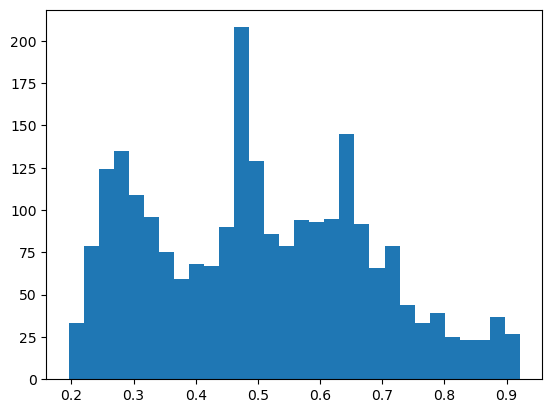

In [250]:
plt.hist(df.prediction, bins=30)
plt.show()

In [ ]:
raise Exception("Stop")

## REGRESSION

In [ ]:
# SAMPLE CODE
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Example data
np.random.seed(42)
categories = np.random.choice(['Group A', 'Group B', 'Group C'], size=1000)
x = np.random.normal(loc=10, scale=2, size=1000)
y = 0.9 * x + np.random.normal(scale=1, size=1000)

# Map categories to colors
category_colors = {
    'Group A': 'red',
    'Group B': 'blue',
    'Group C': 'green'
}

# Create the figure
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4, hspace=0.1, wspace=0.1)

# Main plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
hb = ax_main.hexbin(x, y, gridsize=50, cmap='Purples', mincnt=1)
ax_main.plot([x.min(), x.max()], [x.min(), x.max()], 'gray', linestyle='--')
ax_main.set_xlabel('Predicted Expression')
ax_main.set_ylabel('Measured Expression')

# Add colorbar on the left
cax = fig.add_axes([0.05, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cax, orientation='vertical')
cb.set_label('Density')

# Add correlation text
pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)
n_samples = len(x)
ax_main.text(0.05, 0.95, f"Pearson's r = {pearson_corr:.3f}\nSpearman's r = {spearman_corr:.2f}\nN = {n_samples}",
             transform=ax_main.transAxes, verticalalignment='top', fontsize=12)

# Top histogram
ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_top.hist(x, bins=30, color='gray', edgecolor='black', alpha=0.7)
ax_top.axis('off')

# Right histogram (grouped colors)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
for category in np.unique(categories):
    group_y = y[categories == category]
    ax_right.hist(group_y, bins=30, color=category_colors[category], edgecolor='black', alpha=0.7, orientation='horizontal', label=category)

ax_right.axis('off')
ax_right.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.0), title="Categories")

plt.show()
